# Install libraries 


In [1]:
import sys, os, json
import mne, sklearn, wandb
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker


# animation part
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation


## torch libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary
%load_ext autoreload
%autoreload 2
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils import get_datasets
from utils import preproc
from utils import torch_dataset
from utils import train_utils
from utils import inference
from utils.models_arch import autoencoder_new_Artur

import seaborn as sns
sns.set()

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# CWL DATASET Set all hyperparameters
- Cuda and GPU.
- Parameters of dataset. 
- random seed( if necessary). 


In [2]:
print(torch.cuda.is_available(), torch.cuda.device_count())
torch.cuda.set_device(0)

config = dict(  
                dataset_name = 'CWL_raw', # CWL
                fps = 1000,
                patients = 'trio1',
                new_fps=100, 
                crop_start = 5,
                freqs = [-1], 
    
                n_channels = 30, # 63 
                n_roi = 8,
                
                bold_delay = 6,
                to_many = True,
                random_subsample = True,
                sample_per_epoch = 512, 
                WINDOW_SIZE = 2048,
                    
                optimizer='adamW',
                lr=3e-4,
                weight_decay=3e-4, 
                batch_size=16, 
                
                preproc_type = 'dB_log',
                loss_function = 'mse_corr', 
                model_type = 'Best_AE_Artur_Multi_Head'
                )


hp_autoencoder = dict(n_electrodes=config['n_channels'],
                      n_freqs = len(config['freqs']),
                      n_channels_out = config['n_roi'],

                     channels = [128, 128, 128, 128], 
                     kernel_sizes=[5, 5, 3],
                     strides=[8, 8, 4,], 
                     dilation=[1, 1, 1], 
                     decoder_reduce=4, 
                      hidden_channels=16
                     )


config = {**hp_autoencoder, **config}

params_train = {'batch_size': config['batch_size'],
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': config['batch_size'],
              'shuffle': False}

True 4


# Upload RAW CWL data for Artur Model 
It should accelerate speed of experiments.

Size of train dataset: (30, 20590) (8, 20590)
Size of test dataset: (30, 5400) (8, 5400)
3351
ALL path:  ../data/eyes_open_closed_dataset/trio1/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-off.set ../data/eyes_open_closed_dataset/trio1/CWL_Data/mri/epi_normalized/rwatrio1_eoec_in-scan_hpump-off.nii ../data/eyes_open_closed_dataset/trio1/CWL_Data/mri/epi_motionparams/rp_atrio1_eoec_in-scan_hpump-off.txt


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:173: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_confound = pd.read_csv(motion_params_path, sep = '  ', header=None)


Dimension of our EEG data:  (303601, 31)
Dimension of our fMRi data:  (61, 72, 61, 146)
Dimension of our fMRi Roi data:  (143, 18)
fMRI info :  1.95
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:261: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  return df_eeg, df_fmri, df_fmri.drop(['time'], 1).columns.to_list()
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


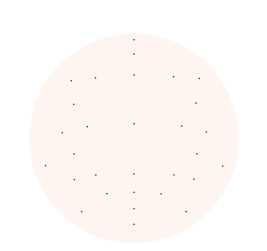

(<matplotlib.image.AxesImage at 0x7ff7d05192b0>,
 <matplotlib.contour.QuadContourSet at 0x7ff7d05195b0>)

In [3]:
with open("../data/interim/labels_roi_17.json", 'r') as f:
    labels_roi_17 = json.load(f)
    
labels_roi = ['Left Pallidum',
                     'Left Caudate',
                     'Left Putamen',
                     'Left Accumbens',
                      
                     'Right Pallidum',
                     'Right Caudate',
                     'Right Putamen',
                     'Right Accumbens']


if config['dataset_name']=='CWL_raw':
    
    dataset_path = f"../data/interim/CWL/{config['patients']}_1000_filtered_data.npz"

elif config['dataset_name']=='NODDI_raw':
    dataset_path = '../data/interim/NODDI/32_250_filtered_data.npz'
else:
    print('no such dataset')



data = np.load(dataset_path)

eeg, fmri = data['eeg'], data['fmri']
df = pd.DataFrame(data = fmri.T, columns=labels_roi_17)
df_filter = df[labels_roi]
fmri = df_filter.to_numpy().T

# crop start
train_crop = config['crop_start']*config['fps']
eeg, fmri = eeg[..., train_crop:], fmri[..., train_crop:]

# normalize 
eeg = eeg / np.std(eeg)
fmri, fmri_means_stds = preproc.normalize_data(fmri)

# train/test split
test_time = int(60*config['fps'])
train_dataset_prep = (eeg[..., :-test_time], fmri[..., :-test_time])
test_dataset_prep = (eeg[..., -test_time:], fmri[..., -test_time:])


ds_factor = config['fps']/config['new_fps']
train_dataset_prep = preproc.downsample_dataset(train_dataset_prep, factor = ds_factor)
test_dataset_prep = preproc.downsample_dataset(test_dataset_prep, factor = ds_factor)





# apply time dealy corrected
train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, 
                                                   config['new_fps'],
                                                   config['bold_delay'])
test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, 
                                                  config['new_fps'],
                                                  config['bold_delay'])


print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

# torch dataset creation 
torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                            random_sample=config['random_subsample'], 
                                                            sample_per_epoch=config['sample_per_epoch'], 
                                                            to_many=config['to_many'], 
                                                            window_size = config['WINDOW_SIZE'])

torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                            random_sample=False, 
                                                            sample_per_epoch=None, 
                                                            to_many=config['to_many'], 
                                                            window_size = config['WINDOW_SIZE'])
print(len(torch_dataset_test))
# because you do not have strid for val data. 
torch_dataset_test = Subset(torch_dataset_test, np.arange(len(torch_dataset_test))[::100])

# init dataloaders for training
train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)
val_loader = torch.utils.data.DataLoader(torch_dataset_test, **params_val)



#----------------------------------------------------#
### INFO FOR TOPOMAPS CWL 
patient = 'trio1'
path_to_dataset = '../data/eyes_open_closed_dataset/'
dataset_name = 'CWL'
remove_confounds = True

df_eeg, df_fmri, _ = get_datasets.download_cwl_dataset(patient, path_to_dataset, 
                                                                    remove_confounds=remove_confounds,
                                                                    verbose=True)

standart_montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=standart_montage.ch_names, sfreq=100, ch_types='eeg')
info = info.pick_channels(ch_names = list(df_eeg.columns)[1:])

epochs = mne.EpochsArray(np.zeros([1, len(info.ch_names), 1]),  info=info)
epochs.set_montage(standart_montage)
info = epochs.info
x = np.zeros(30)
mne.viz.plot_topomap(x, pos = info)

# Model Inference

## Init Model

In [4]:
hp_autoencoder = dict(n_electrodes=config['n_channels'],
                      n_freqs = len(config['freqs']),
                      n_channels_out = config['n_roi'],

                     channels = [128, 128, 128, 128], 
                     kernel_sizes=[5, 5, 3],
                     strides=[8, 8, 4,], 
                     dilation=[1, 1, 1], 
                     decoder_reduce=4, 
                      hidden_channels=16
                     )
weight_path = 'wandb/run-20220517_155127-1myycb0h/files/epoch_1564_val_corr0.48.pt'

model = autoencoder_new_Artur.AutoEncoder1D_Artur_MultiHead(hp_autoencoder)

print(summary(model, torch.zeros(4, config['n_channels'],
                                 config['WINDOW_SIZE']), show_input=False))


model.load_state_dict(torch.load(weight_path))
model.eval()

print('s')

HOW:  {'n_electrodes': 30, 'n_freqs': 1, 'n_channels_out': 8, 'channels': [128, 128, 128, 128], 'kernel_sizes': [5, 5, 3], 'strides': [8, 8, 4], 'dilation': [1, 1, 1], 'decoder_reduce': 4, 'hidden_channels': 16}
HUI 8
-----------------------------------------------------------------------------
            Layer (type)        Output Shape         Param #     Tr. Param #
   AutoEncoder1D_Artur-1        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-2        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-3        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-4        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-5        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-6        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-7        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-8        [4, 1, 2048]         245,057         245,057
Total param

(8, 5120)
(8, 5120)


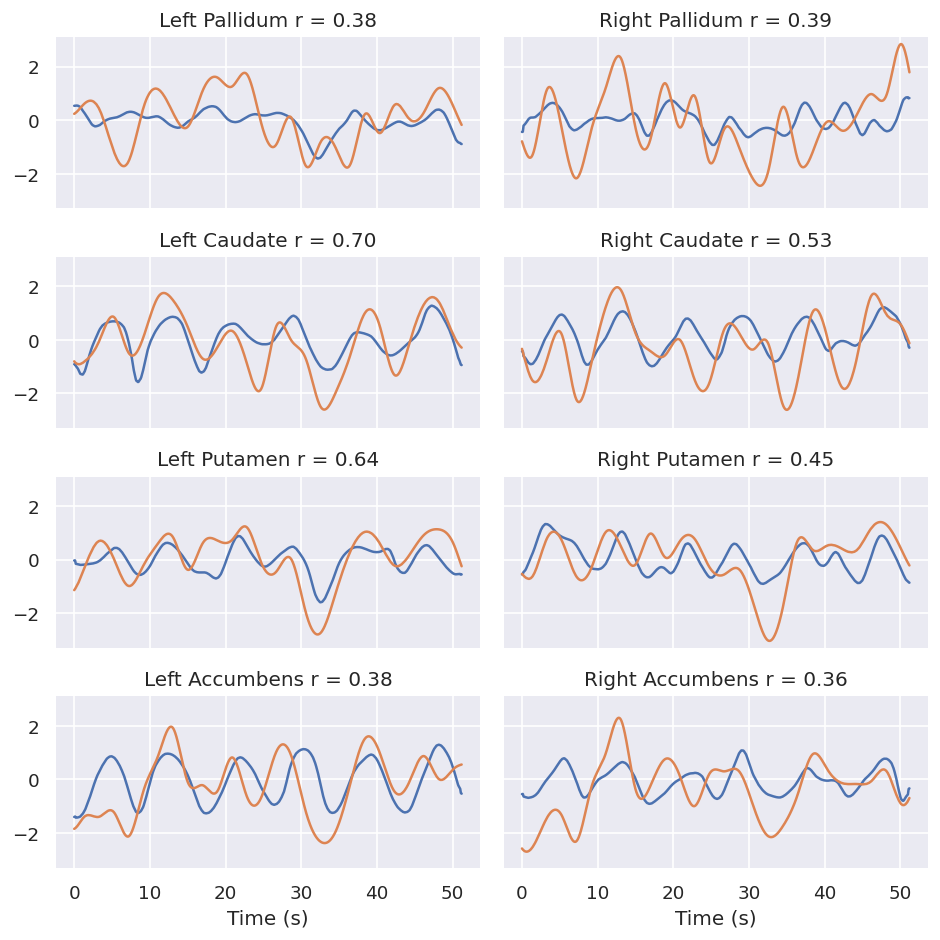

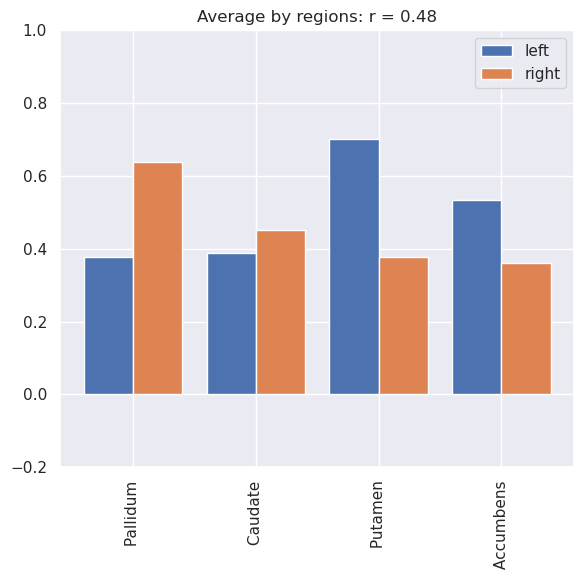

In [5]:
raw_test_data = test_dataset_prep
# labels = labels_roi_6
labels = labels_roi

inference_function = inference.model_inference_function
device = 'cuda'
to_many = True

fig, fig_bars, corrs = inference_function(model, raw_test_data, 
                                          labels=labels, 
                                          device=device, 
                                          to_many=to_many)



In [135]:
# fig.savefig('../figures/ts_best_MH_Artur_AE_8_ROI_0_48_final.pdf')
# fig_bars.savefig('../figures/bars_best_MH_Artur_AE_0_47.pdf') 

# Model Interpretation 


## Apply patterns interpretation

In [6]:
from sklearn.preprocessing import minmax_scale

def extract_spatial_patterns(eeg, weights, freq_filters):
    """
    eeg - (30,
    weights shape (n_branch, n_elcctrodes ) 
    
    
    freq_filters - [5, 1, 51]
    
    1. Apply band pass filter for all weight 
    2. Get covariance of the filtered data 
    3. Multiply covariance on the weights
    """
    n_heads, n_electrodes = weights.shape
    
    patterns_list = []
    
    for head_idx in range(n_heads):
        
        weight = weights[head_idx]
        freq_weight = freq_filters[head_idx] # [1, 51]

        # 1  apply band filter 
        X = eeg.unsqueeze(0).float()    
        freq_weight = freq_weight.repeat(n_electrodes, 1, 1)
        X_filter = F.conv1d(X, freq_weight, padding ='same', groups=n_electrodes)[0]

        # 2 Take covariance
        X_filter_cov = torch.cov(X_filter)

        # 3. Get patterns  
        pattern = torch.matmul(X_filter_cov, weight)
        patterns_list.append(pattern)
    return torch.stack(patterns_list)
    
def compute_fft(data, fps):
    """
    Return (freqs, amplitudes)
    """
    n = data.shape[0]
    values = torch.fft.rfft(data, n=n, norm ='forward' )[:n//2] # forward means 1/n
    freqs = torch.fft.fftfreq(n=n, d=1/fps)[:values.shape[0]]
    return freqs, values

def extract_freq_patterns(eeg, weights, freq_filters, fps = 100):
    """
    eeg - (30,
    weights shape (n_branch, n_elcctrodes ) 
    
    
    freq_filters - [5, 1, 51]
    
    
    Return 
        freqs_list_kernel, torch.stack(patterns_list), torch.stack(patterns_list)
    list of freqs, patterns for all roi, weights for all roi
    """
    n_heads, n_electrodes = weights.shape
    
    patterns_list = []
    fft_kernels_list= []
    fft_signal_list = []
    
    for head_idx in range(n_heads):
        
        weight = weights[head_idx]
        freq_weight = freq_filters[head_idx][0] # [51]
        X = eeg.unsqueeze(0).float()
        
        # 1  apply spatial filter        
        X_one_head = torch.matmul(weight, X)[0]
        
        
        # 1. approach.
#         freq_weight = freq_weight.reshape((1, 1, -1))
#         X_one_head = X_one_head.reshape((1, 1,-1)) 
#         X_head_filter = F.conv1d(X_one_head, freq_weight, padding ='same', groups=1)[0][0]
#         freqs_list, values = compute_fft(X_head_filter, 100)
#         values = torch.abs(values)
        
#         values = F.interpolate(values.reshape(1, 1, -1), size=freq_weight.shape[-1]//2, mode='nearest').squeeze()
#         patterns_list.append(values)
        
        # 2. 
        
        freqs_list_kernel, fft_kernel = compute_fft(freq_weight, fps)
        freqs_list_signal, fft_signal = compute_fft(X_one_head, fps)
        fft_kernel =  torch.abs(fft_kernel)
        fft_signal = torch.abs(fft_signal)
        
        # take the same as kernel
        fft_signal_interp = F.interpolate(fft_signal.reshape(1, 1, -1), 
                                          size=fft_kernel.shape[0], mode='nearest').squeeze()
        
        
        # fft_kernel = minmax_scale(fft_kernel.reshape(1, -1), axis =-1)[0]
        pattern = fft_signal_interp * fft_kernel
        
        
        fft_kernels_list.append(fft_kernel)
        patterns_list.append(pattern)
        
    freqs_list_kernel, fft_kernel = compute_fft(freq_weight.squeeze(), fps)
    return freqs_list_kernel, torch.stack(patterns_list), torch.stack(fft_kernels_list) 
    


## Calculate all patterns

In [7]:
all_spatial_patterns = []
all_freq_patterns = []
all_freq_weights = []


n_roi = len(labels)
for roi_idx in range(n_roi):
    model_roi = model.models[roi_idx]

    weights = torch.squeeze(model_roi.artur_block.unmixing_layer.weight).detach().cpu()
    freq_filters = model_roi.artur_block.band_pass.weight.cpu().detach()
    eeg = torch.from_numpy(raw_test_data[0]).float()
    
    print('ALL sizes:', weights.shape, freq_filters.shape, eeg.shape)

    spatial_patterns = extract_spatial_patterns(eeg, weights, freq_filters)
    freqs_list, fft_patterns, fft_weights = extract_freq_patterns(eeg, weights, freq_filters)
    
    
    all_spatial_patterns.append(spatial_patterns)
    all_freq_patterns.append(fft_patterns)
    all_freq_weights.append(fft_weights)
    
    

ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])


## Get the most influential braches based on gradients 

In [8]:
from captum.attr import Saliency, LayerFeatureAblation, LayerGradientXActivation
x_batch = np.expand_dims(raw_test_data[0], 0).astype('float32')
x_batch = torch.tensor(x_batch, requires_grad=True).cpu()
# x_batch.grad.zero_()
# Gradient by some layers. 

top_branches = 3

all_top_idxs = []
for roi_idx in range(n_roi):
    one_model = model.models[roi_idx].cpu()
    layer = LayerGradientXActivation(one_model, one_model.artur_block)
    # for all prediction.
    layer_attr = []
    for t in range(0, x_batch.shape[-1], 100):
        attr = layer.attribute(x_batch, target=(0, t))
        attr = np.abs(attr.detach().numpy()[0])
        attr = np.mean(attr, -1)
        layer_attr.append(attr)

    # average across time 
    layer_attr = np.stack(layer_attr, 0)
    branch_influence = np.mean(layer_attr, 0)
    # take top the most influential
    sorted_idxs = np.argsort(branch_influence)
    top_idxs = sorted_idxs[-top_branches:]
    all_top_idxs.append(top_idxs)
all_top_idxs = np.stack(all_top_idxs, 0).astype('int')

In [9]:

# get best branches
all_spatial_patterns = [pat[idxs] for pat, idxs in zip(all_spatial_patterns, all_top_idxs)]
all_freq_weights = [pat[idxs] for pat, idxs in zip(all_freq_weights, all_top_idxs)]

## Plot topomaps 

### Topomaps

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

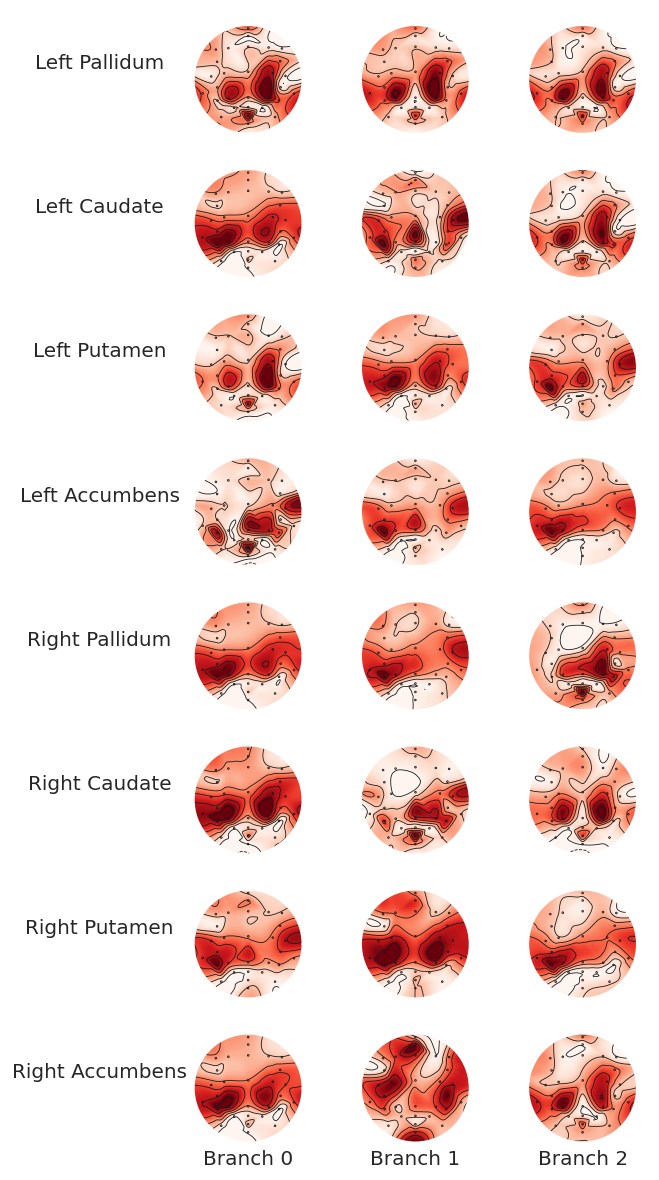

In [10]:
n_branch = top_branches
fig, ax = plt.subplots(n_roi, n_branch, figsize = (6, 10), sharex=True, dpi = 120,squeeze=False)
for roi in range(n_roi):
    # get v_min and v_max for each RoI
    # vmax = np.max([torch.max(pat) for pat in all_spatial_patterns[roi]])
    # vmin = np.min([torch.min(pat) for pat in all_spatial_patterns[roi]])
        # get v_min and v_max for each RoI
    # vmax = np.max([torch.max(torch.abs(pat)) for pat in all_spatial_patterns[roi]])
    # vmin = np.min([torch.min(torch.abs(pat)) for pat in all_spatial_patterns[roi]])
    # print(vmin, vmax)
    
    for i in range(n_branch):
        # mne.viz.plot_topomap(all_spatial_patterns[roi][i], pos = info,
        #                      vmin = vmin, vmax =vmax, show=False, axes = ax[roi, i])
        mne.viz.plot_topomap(torch.abs(all_spatial_patterns[roi][i]), pos = info, show=False, axes = ax[roi, i], 
                            extrapolate='head')
        ax[roi, i].set(xlabel=f"Branch {i}")
        ax[roi, i].set_ylabel(f"{labels[roi]}", rotation=0, labelpad=50)
        


    
for ax in ax.flat:
    ax.label_outer()
# plt.colorbar()
plt.tight_layout()


In [11]:
# fig.savefig('../figures/all_topomaps_CWL_fixed_8_ROI_top_1.pdf')


## Plot time freq maps

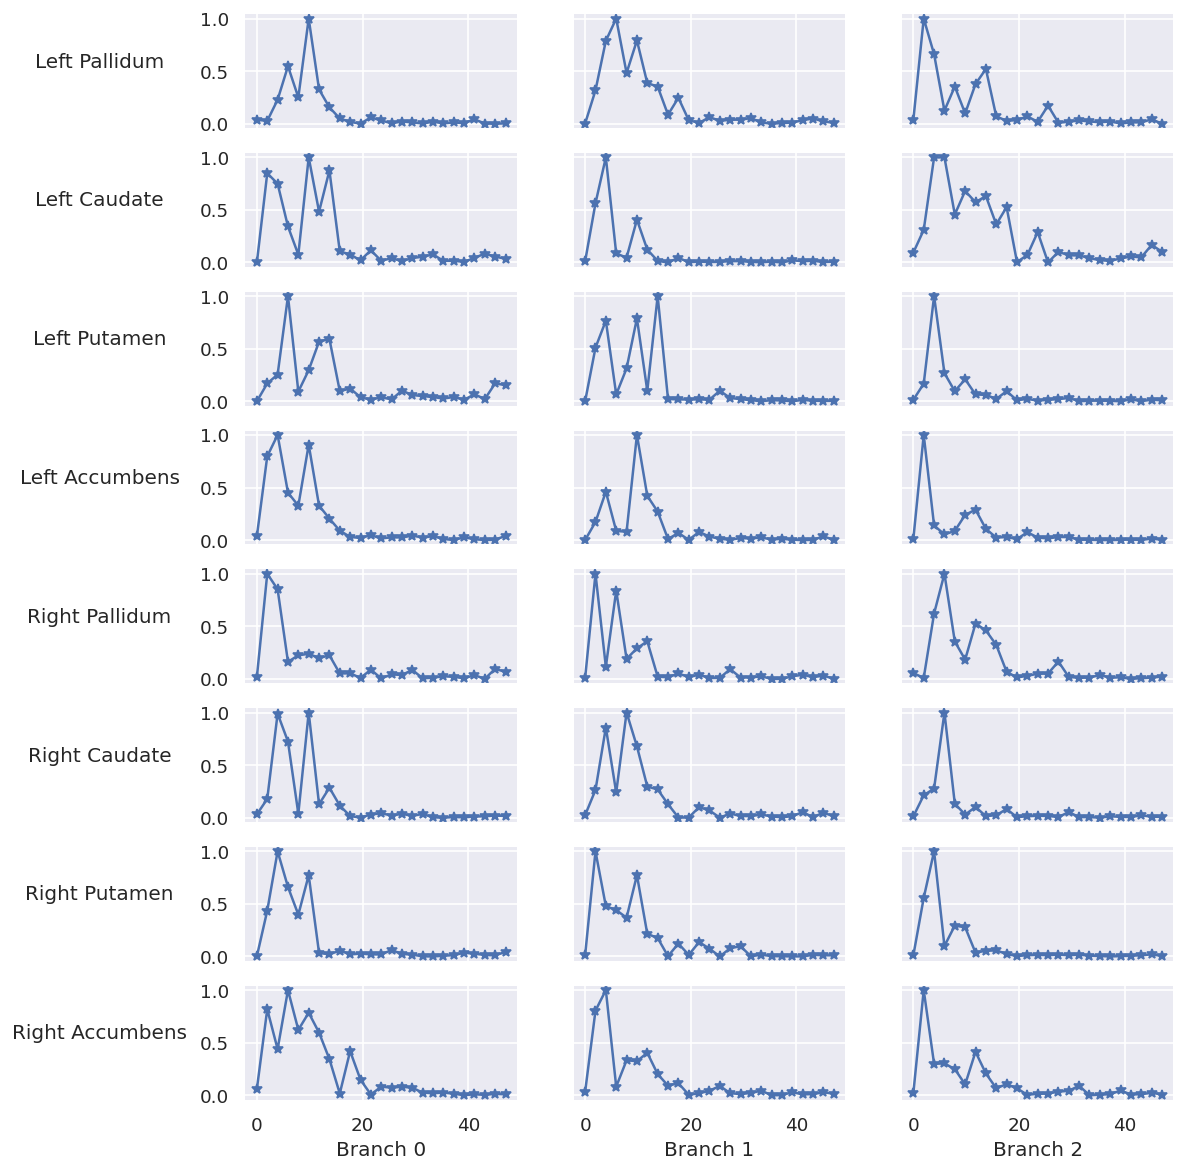

In [12]:
from sklearn.preprocessing import MinMaxScaler

n_roi = len(labels)
n_branch = top_branches
fig, ax = plt.subplots(n_roi, n_branch, figsize = (10, 12), sharex=True, sharey=True,squeeze=False, dpi=120)
for roi in range(n_roi):
    # vmax = np.max([torch.max(pat) for pat in all_freq_patterns[roi]])
    # vmax_weight = np.max([torch.max(pat) for pat in all_freq_weights[roi]])
    scaler = MinMaxScaler()
    # scaler.fit(all_freq_patterns[roi].reshape(-1, 1))
    
    # scaler_weight = MinMaxScaler()
    # scaler_weight.fit(all_freq_weights[roi].reshape(-1, 1))
    # scaler.fit(all_freq_patterns[roi].T)
    
    
    for i in range(n_branch):
        # pattern = minmax_scale(all_freq_patterns[roi][i].reshape(1, -1),axis= -1)[0]
        # weight = minmax_scale(all_freq_weights[roi][i].reshape(1, -1),axis= -1)[0]
#         pattern = all_freq_patterns[roi][i] / vmax
#         weight = all_freq_weights[roi][i] / vmax_weight
        
        # pattern = np.convolve(pattern, np.ones(5)/5, 'SAME')
#         weight = np.convolve(weight, np.ones(5)/5, 'SAME')
        
        pattern = all_freq_patterns[roi][i]
        weight = all_freq_weights[roi][i]

        
        # scale to minmax for all RoI
        
        pattern = scaler.fit_transform(pattern.reshape(-1, 1))[:, 0]
        weight = scaler.transform(weight.reshape(-1, 1))[:, 0]


        
        # pattern = np.convolve(pattern, np.ones(3)/3, 'SAME')
        # weight = np.convolve(weight, np.ones(3)/3, 'SAME')


        ax[roi, i].plot(freqs_list, pattern , '*-', label='patterns(smooth)')
        # ax[roi, i].plot(freqs_list, weight  , '*-', label='weights')
        

        # mne.viz.plot_topomap(all_freq_patterns[roi][i], pos = info, show=False, axes = ax[roi, i])
        ax[roi, i].set(xlabel=f"Branch {i}")
        ax[roi, i].set_ylabel(f"{labels[roi]}", rotation=0, labelpad=60)
    

    
#     
    

for ax in ax.flat:
    # ax.set(xlabel='x-label', ylabel='y-label')
    ax.label_outer()
    # ax.set_xticklabels(labels, rotation=45, ha='right')



# for ax in fig.axes:
axLine, axLabel = fig.axes[0].get_legend_handles_labels()


    
# fig.legend(axLine, axLabel,           
#            loc = 'right')
# for ax in axs.flat:
    

In [13]:
# fig.savefig('../figures/all_time_freq_maps_8_ROI_top_3_branch.pdf')

## Combine 

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

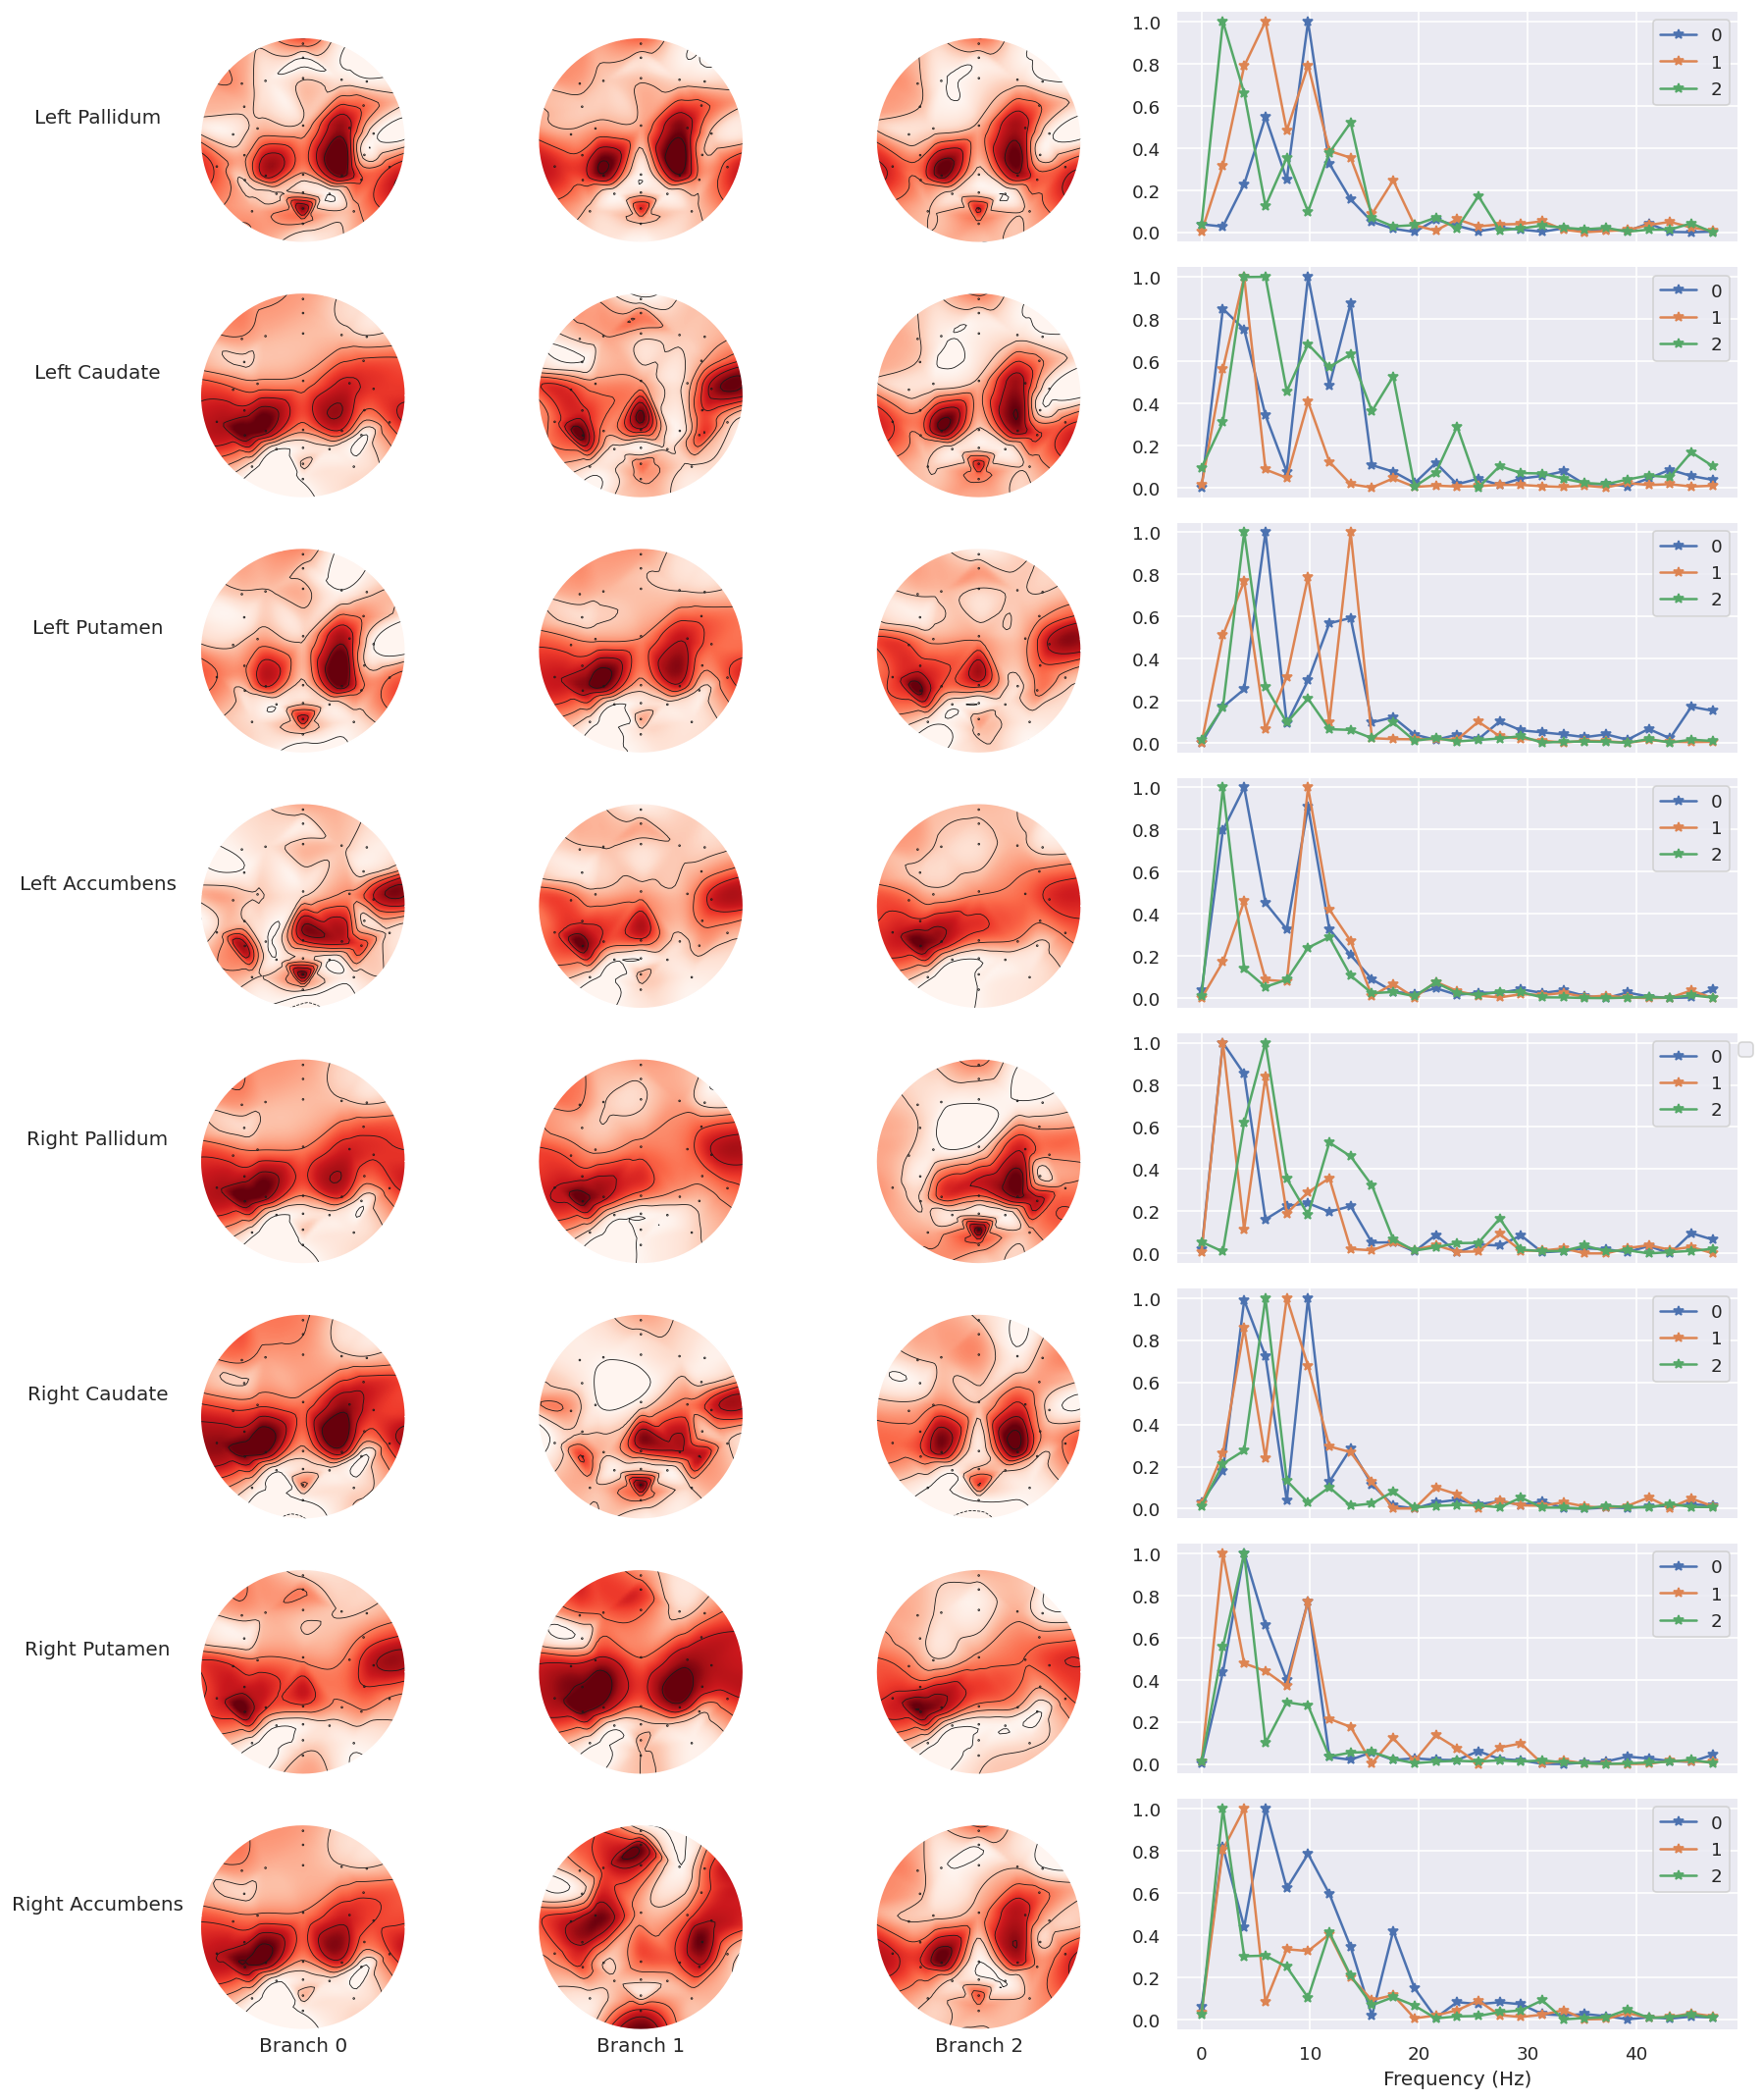

In [14]:
from sklearn.preprocessing import MinMaxScaler

n_roi = len(labels)
n_branch = top_branches
fig, ax = plt.subplots(n_roi, n_branch+1, figsize = (15, 18), sharex='col', sharey=False,squeeze=False, dpi=120, 
                      gridspec_kw={'width_ratios': [1, 1, 1, 2]})
for roi in range(n_roi):
    scaler = MinMaxScaler()    
    for i in range(n_branch):    
        pattern = all_freq_patterns[roi][i]
        pattern = scaler.fit_transform(pattern.reshape(-1, 1))[:, 0]
        # pattern = np.convolve(pattern, np.ones(3)/3, 'SAME')
        
        ax[roi, -1].plot(freqs_list, pattern , '*-', label='branch' + str(i))
        ax[roi, -1].legend("012 ",loc="upper right")
        # ax[roi, -1].set_xlabel('Frequency (Hz)')
        # ax[roi, -1].label_outer()
        # ax[roi, i].set(xlabel=f"Branch {i}")
        # ax[roi, i].set_ylabel(f"{labels[roi]}", rotation=0, labelpad=60)
    
ax[-1, -1].set_xlabel('Frequency (Hz)')


for roi in range(n_roi):
    for i in range(n_branch):
        mne.viz.plot_topomap(torch.abs(all_spatial_patterns[roi][i]), pos = info, show=False, axes = ax[roi, i], 
                            extrapolate='head')
        # mne.viz.plot_topomap(all_spatial_patterns[roi][i], pos = info, show=False, axes = ax[roi, i], 
                            # extrapolate='head')
        ax[roi, i].set(xlabel=f"Branch {i}")
        ax[roi, i].set_ylabel(f"{labels[roi]}", rotation=0, labelpad=50)
        ax[roi, i].label_outer()
        


plt.tight_layout()

# for ax in ax.flat:
#     ax.label_outer()



axLine, axLabel = fig.axes[0].get_legend_handles_labels()
fig.legend(axLine, axLabel,           
           loc = 'right')


# for ax in axs.flat:
    

In [15]:
# fig.savefig('../figures/combine_all_ROI_8_3_branch_final_abs_v2.pdf')